In [1]:
from matplotlib.colors import ListedColormap

# define custom colormap using color names (in order of corresponding networks: 1 visual, 2 sensorimotor, 3 dorsal attention, 4 ventral attention, 5 limbic, 6 fronto parietal, 7 DMN)
colors_yeo7 = ['darkorchid', 'steelblue', 'forestgreen', 'orchid', 'lemonchiffon', 'orange',  'indianred']

yeo7_colormap = ListedColormap(colors_yeo7, 'custom_colormap')

yeo7_colormap

import os
import glob
import numpy as np
import nibabel as nib
import pandas as pd
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import matplotlib.pyplot as plt


subj_dir = '/media/garlicseed/data2/Schizophrenia/derivate/micapipe_v0.2.0/'
atlas='schaefer-400' 
micapipe='/media/garlicseed/data2/Schizophrenia' # <<<<<<<<<<<< CHANGE THIS PATH
# Load fsLR-32k
f32k_lh = read_surface(f'{micapipe}/surfaces/fsLR-32k.L.surf.gii', itype='gii')
f32k_rh = read_surface(f'{micapipe}/surfaces/fsLR-32k.R.surf.gii', itype='gii')

# Load fsaverage5
fs5_lh = read_surface(f'{micapipe}/surfaces/lh.pial', itype='fs')
fs5_rh = read_surface(f'{micapipe}/surfaces/rh.pial', itype='fs')

# Load LEFT annotation file in fsaverage5
annot_lh_fs5= nib.freesurfer.read_annot(f'{micapipe}/parcellations/lh.{atlas}_mics.annot')

# Unique number of labels of a given atlas
Ndim = max(np.unique(annot_lh_fs5[0]))

# Load RIGHT annotation file in fsaverage5
annot_rh_fs5= nib.freesurfer.read_annot(f'{micapipe}/parcellations/rh.{atlas}_mics.annot')[0]+Ndim

# replace with 0 the medial wall of the right labels
annot_rh_fs5 = np.where(annot_rh_fs5==Ndim, 0, annot_rh_fs5)

# fsaverage5 labels
labels_fs5 = np.concatenate((annot_lh_fs5[0], annot_rh_fs5), axis=0)

# Mask of the medial wall on fsaverage 5
mask_fs5 = labels_fs5 != 0

# Read label for fsLR-32k
labels_f32k = np.loadtxt(open(f'{micapipe}/parcellations/{atlas}_conte69.csv'), dtype=int)

# mask of the medial wall
mask_f32k = labels_f32k != 0
subj_dir = '/media/garlicseed/data2/Schizophrenia/derivate/micapipe_v0.2.0/'

wkDir = '/media/garlicseed/data2/Schizophrenia/'
df = pd.read_csv(f'{wkDir}/participants_train.tsv', sep='\t')

In [2]:
yeo7_networks_array = np.genfromtxt('/media/garlicseed/data2/Schizophrenia/surfaces/schaefer400x7CommunityAffiliation.1D', delimiter=',', skip_header=0)
# original Yeo network colors
palette_labeled_networks = {'DMN': 'indianred',  
                            'dorsal attention' : 'forestgreen',  
                            'fronto parietal' : 'orange',  
                            'limbic' : 'lemonchiffon',  
                            'sensory motor' : 'steelblue',
                            'ventral attention' : 'orchid', 
                            'visual' : 'darkorchid'} 
# making an array with yeo network labels (names instead of numbers)
yeo7_networks_array_labels = []

for i in yeo7_networks_array:
    if i == 1:
        yeo7_networks_array_labels.append('visual')
    elif i == 2:
        yeo7_networks_array_labels.append('sensory motor')
    elif i == 3:
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == 4:
        yeo7_networks_array_labels.append('ventral attention')
    elif i == 5:
        yeo7_networks_array_labels.append('limbic')
    elif i == 6:
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == 7:
        yeo7_networks_array_labels.append('DMN')

yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)
network_names = ["visual", "sensory motor", "dorsal attention", "ventral attention", "limbic", "fronto parietal", "DMN"]

print("Number of parcels in each Yeo network:")
for i in range(len(network_names)):
    print(f"- {network_names[i]}: {yeo7_networks_array_labels.tolist().count(network_names[i])}")

Number of parcels in each Yeo network:
- visual: 61
- sensory motor: 77
- dorsal attention: 46
- ventral attention: 47
- limbic: 26
- fronto parietal: 52
- DMN: 91


In [3]:
def compute_aligned_gradients(conn_matrices, mean_grad_for_alignment, data_reduction_algorithm = 'dm'):
    
 
    
    list_aligned_gradients = []  
    list_aligned_G1 = []  
    list_aligned_G2 = []  
    list_aligned_G3 = []  

    # loop over all the connectivity matrices
    for i in range(len(conn_matrices)):
        # setting model parameters for gradients to be computed across subjects - with procrustes alignment
        grad_procr = GradientMaps(n_components=20, random_state=0, approach = data_reduction_algorithm, kernel='normalized_angle', alignment='procrustes')  # specify alignment method here (procrustes)

        # computing
        # note that by using an alignment method, .fit yields a variable (grad_procr) containing both types of gradients, callable with: .gradients_ (original) and .aligned_ 
          # use ._gradients for mean_grad_for_alignment (mean grad was not even calculated with a reference so doesn't have ._aligned) and use .aligned_ for grad_procr 

        grad_procr.fit(conn_matrices[i], reference=mean_grad_for_alignment)  # align to the gradients of the gradients produced by the mean matrix (reference) 

        # append array to lists results (.T is necessary in order to be able to first access the gradients layer (10) so that can index the desired gradient, which will then contain all the parcels (400)
        list_aligned_gradients.append(grad_procr.aligned_)
        list_aligned_G1.append(grad_procr.aligned_.T[0])
        list_aligned_G2.append(grad_procr.aligned_.T[1])
        list_aligned_G3.append(grad_procr.aligned_.T[2])

    # make gradient lists into arrays (for analyses)    
    array_aligned_gradients = np.array(list_aligned_gradients)
    array_aligned_G1 = np.array(list_aligned_G1)
    array_aligned_G2 = np.array(list_aligned_G2)
    array_aligned_G3 = np.array(list_aligned_G3)        
    ### dictionary to output    
    dict_output = {'array_aligned_gradients': array_aligned_gradients, 'array_aligned_G1': array_aligned_G1, 'array_aligned_G2': array_aligned_G2, 'array_aligned_G3': array_aligned_G3}    
    return dict_output

In [132]:
#g1 g2 g3 seperately for sch and hc 这种方法为分开计算左右脑功能梯度，很麻烦，容易出错，不推荐
# creating lists containing only sch and only hc matrices
output_dir = '/media/garlicseed/data2/Schizophrenia/FG_train'
import pandas as pd
fc_stack = np.load(f'{wkDir}/FC_train/fc_matrices.npy')
fc_matrices_lh = fc_stack.T[:200,:200].T
fc_matrices_rh = fc_stack.T[200:,200:].T
    
schz_mask = df['diagnosis'] == 'SCHZ'
hc_mask = df['diagnosis'] == 'CONTROL'
fc_matrices_lh_SCH = fc_matrices_lh[schz_mask]
fc_matrices_rh_SCH = fc_matrices_rh[schz_mask]
fc_matrices_SCH = fc_stack[schz_mask]
fc_matrices_lh_HC = fc_matrices_lh[hc_mask]
fc_matrices_rh_HC = fc_matrices_rh[hc_mask]

##### for schizophrenia ######        
# 函数：计算平均连接矩阵并拟合梯度
def compute_gradients(fc_matrices, n_components=10, random_state=0):
    # 计算平均连接矩阵
    mean_fc_matrix = np.mean(fc_matrices, axis=0)
    
    # 创建并拟合梯度映射
    grad_model = GradientMaps(n_components=n_components, 
                             random_state=random_state, 
                             approach='dm', 
                             kernel='normalized_angle')
    grad_model.fit(mean_fc_matrix)
    
    return mean_fc_matrix, grad_model

# 计算精神分裂症组的梯度
mean_fc_matrix_lh_SCH, mean_fc_grad_lh_SCH = compute_gradients(fc_matrices_lh_SCH)
mean_fc_matrix_rh_SCH, mean_fc_grad_rh_SCH = compute_gradients(fc_matrices_rh_SCH)

# Variance explained by the gradients

mean_lambdas_lh_rh_SCH = np.mean(np.array([mean_fc_grad_lh_SCH.lambdas_,mean_fc_grad_rh_SCH.lambdas_]), axis=0)

print(f"Total amount of variance explained by the {len(mean_lambdas_lh_rh_SCH)} gradients (uncorrected sum lambdas): {sum(mean_lambdas_lh_rh):.2f}\n")

# Scaled variance explained by individual gradients: lambda / total(i.e., sum lambdas) * 100 %
print(f"Scaled variance explained by individual gradients:\nG1: {mean_lambdas_lh_rh_SCH[0]/sum(mean_lambdas_lh_rh_SCH)*100:.2f}%\nG2: {mean_lambdas_lh_rh_SCH[1]/sum(mean_lambdas_lh_rh_SCH)*100:.2f}%\nG3: {mean_lambdas_lh_rh_Sch[2]/sum(mean_lambdas_lh_rh_Sch)*100:.2f}%")

# 计算健康对照组的梯度
mean_fc_matrix_lh_HC, mean_fc_grad_lh_HC = compute_gradients(fc_matrices_lh_HC)
mean_fc_matrix_rh_HC, mean_fc_grad_rh_HC = compute_gradients(fc_matrices_rh_HC)


mean_fc_matrix_SCH, mean_fc_grad_SCH = compute_gradients(fc_matrices_SCH)
mean_fc_matrix_HC, mean_fc_grad_HC = compute_gradients(fc_matrices_HC)


# 函数：计算对齐梯度并保存结果
def align_and_save_gradients(fc_matrices_lh, fc_matrices_rh, 
                            mean_grad_lh, mean_grad_rh,
                            group_name, output_dir):

   
    # 对齐梯度
    compute_aligned_grad_lh = compute_aligned_gradients(
        conn_matrices=fc_matrices_lh, 
        mean_grad_for_alignment=mean_grad_lh.gradients_, 
        data_reduction_algorithm='dm')
    
    compute_aligned_grad_rh = compute_aligned_gradients(
        conn_matrices=fc_matrices_rh, 
        mean_grad_for_alignment=mean_grad_rh.gradients_* -1, 
        data_reduction_algorithm='dm')
    
    # 提取对齐后的G1和G2
    array_aligned_G1_lh = compute_aligned_grad_lh['array_aligned_G1']
    array_aligned_G1_rh = compute_aligned_grad_rh['array_aligned_G1']
    array_aligned_G2_lh = compute_aligned_grad_lh['array_aligned_G2']
    array_aligned_G2_rh = compute_aligned_grad_rh['array_aligned_G2']
    array_aligned_G3_lh = compute_aligned_grad_lh['array_aligned_G3']
    array_aligned_G3_rh = compute_aligned_grad_rh['array_aligned_G3']
    # 合并左右半球
    aligned_G1 = np.concatenate((array_aligned_G1_lh, array_aligned_G1_rh), axis=1)
    aligned_G2 = np.concatenate((array_aligned_G2_lh, array_aligned_G2_rh), axis=1)
    aligned_G3 = np.concatenate((array_aligned_G3_lh, array_aligned_G3_rh), axis=1)
    
    # 保存结果
    np.save(f"{output_dir}/aligned_G1_{group_name}.npy", aligned_G1)
    np.save(f"{output_dir}/aligned_G2_{group_name}.npy", aligned_G2)
    
    # 同时保存左右半球的单独结果
    np.save(f"{output_dir}/aligned_G1_lh_{group_name}.npy", array_aligned_G1_lh)
    np.save(f"{output_dir}/aligned_G1_rh_{group_name}.npy", array_aligned_G1_rh)
    np.save(f"{output_dir}/aligned_G2_lh_{group_name}.npy", array_aligned_G2_lh)
    np.save(f"{output_dir}/aligned_G2_rh_{group_name}.npy", array_aligned_G2_rh)
    
    print(f"保存了{group_name}组的梯度数据")
    
    return aligned_G1, aligned_G2, aligned_G3

# 对齐并保存精神分裂症组的梯度（使用HC组的平均梯度作为模板）
aligned_fc_G1_SCH, aligned_fc_G2_SCH, aligned_fc_G3_SCH= align_and_save_gradients(
    fc_matrices_lh_SCH, fc_matrices_rh_SCH,
#    mean_fc_grad_lh_HC, mean_fc_grad_rh_HC,  # 使用HC组的平均梯度作为参考
    mean_fc_grad_lh_SCH, mean_fc_grad_rh_SCH,
    'SCH', output_dir)


# 对齐并保存健康对照组的梯度
aligned_fc_G1_HC, aligned_fc_G2_HC, aligned_fc_G3_HC = align_and_save_gradients(
    fc_matrices_lh_HC, fc_matrices_rh_HC,
    mean_fc_grad_lh_HC, mean_fc_grad_rh_HC,
    'HC', output_dir)

# 打印形状信息以验证
print(f"SCH G1形状: {aligned_fc_G1_SCH.shape}")
print(f"SCH G2形状: {aligned_fc_G2_SCH.shape}")
print(f"HC G1形状: {aligned_fc_G1_HC.shape}")
print(f"HC G2形状: {aligned_fc_G2_HC.shape}")
#

Total amount of variance explained by the 10 gradients (uncorrected sum lambdas): 0.35

Scaled variance explained by individual gradients:
G1: 17.01%
G2: 15.58%
G3: 14.22%
保存了SCH组的梯度数据
保存了HC组的梯度数据
SCH G1形状: (120, 400)
SCH G2形状: (120, 400)
HC G1形状: (212, 400)
HC G2形状: (212, 400)


In [62]:
#g1 g2 g3 seperately for sch and hc 
# creating lists containing only sch and only hc matrices         
output_dir = '/media/garlicseed/data2/Schizophrenia/FG_train'
import pandas as pd
fc_stack = np.load(f'{wkDir}/FC_train/fc_matrices.npy')
fc_matrices_lh = fc_stack.T[:200,:200].T
fc_matrices_rh = fc_stack.T[200:,200:].T
    
schz_mask = df['diagnosis'] == 'SCHZ'
hc_mask = df['diagnosis'] == 'CONTROL'
fc_matrices_SCH = fc_stack[schz_mask]
fc_matrices_HC = fc_stack[hc_mask]
   
# 函数：计算平均连接矩阵并拟合梯度
def compute_gradients(fc_matrices, n_components=20, random_state=0):
    # 计算平均连接矩阵
    mean_fc_matrix = np.mean(fc_matrices, axis=0)
    
    # 创建并拟合梯度映射
    grad_model = GradientMaps(n_components=n_components, 
                             random_state=random_state, 
                             approach='dm', 
                             kernel='cosine')
    grad_model.fit(mean_fc_matrix)
    
    return mean_fc_matrix, grad_model

# 计算精神分裂症组的梯度
mean_fc_matrix_SCH, mean_fc_grad_SCH = compute_gradients(fc_matrices_SCH)

# 计算对照组的梯度
mean_fc_matrix_HC, mean_fc_grad_HC = compute_gradients(fc_matrices_HC)


# 函数：计算对齐梯度并保存结果
def align_and_save_gradients(fc_matrices,  mean_grad, group_name, output_dir):

   
    # 对齐梯度
    compute_aligned_grad = compute_aligned_gradients(
        conn_matrices= fc_matrices, 
        mean_grad_for_alignment=mean_grad.gradients_, 
        data_reduction_algorithm='dm')
        
    # 提取对齐后的G1和G2
    aligned_G1 = compute_aligned_grad['array_aligned_G1']
    aligned_G2 = compute_aligned_grad['array_aligned_G2']
    aligned_G3 = compute_aligned_grad['array_aligned_G3']
    
    # 保存结果
    np.save(f"{output_dir}/aligned_G1_{group_name}.npy", aligned_G1)
    np.save(f"{output_dir}/aligned_G2_{group_name}.npy", aligned_G2)
    np.save(f"{output_dir}/aligned_G3_{group_name}.npy", aligned_G3)    
    print(f"保存了{group_name}组的梯度数据")
    
    return aligned_G1, aligned_G2, aligned_G3

# 对齐并保存精神分裂症组的梯度（使用HC组的平均梯度作为模板）
aligned_fc_G1_SCH, aligned_fc_G2_SCH, aligned_fc_G3_SCH= align_and_save_gradients(
     fc_matrices_SCH, mean_fc_grad_HC,'SCH', output_dir)


# 对齐并保存健康对照组的梯度
aligned_fc_G1_HC, aligned_fc_G2_HC, aligned_fc_G3_HC = align_and_save_gradients(
     fc_matrices_HC, mean_fc_grad_HC,'HC', output_dir)

# 连接 G1 组的 SCH 和 HC 数据
aligned_fc_G1 = np.concatenate([aligned_fc_G1_SCH, aligned_fc_G1_HC], axis=0)
np.save(f'{output_dir}/aligned_fc_G1.npy', aligned_fc_G1)

# 连接 G2 组的 SCH 和 HC 数据
aligned_fc_G2 = np.concatenate([aligned_fc_G2_SCH, aligned_fc_G2_HC], axis=0)
np.save(f'{output_dir}/aligned_fc_G2.npy', aligned_fc_G2)
# 打印形状信息以验证
print(f"SCH G1形状: {aligned_fc_G1_SCH.shape}")
print(f"SCH G2形状: {aligned_fc_G2_SCH.shape}")
print(f"HC G1形状: {aligned_fc_G1_HC.shape}")
print(f"HC G2形状: {aligned_fc_G2_HC.shape}")


保存了SCH组的梯度数据
保存了HC组的梯度数据
SCH G1形状: (120, 400)
SCH G2形状: (120, 400)
HC G1形状: (212, 400)
HC G2形状: (212, 400)


In [11]:
#按照sch和hc两种进行保存df
df_train_sch = df[schz_mask]
df_train_hc = df[hc_mask]
df_train = pd.concat([df_train_sch, df_train_hc], ignore_index=True)
df_train['participant_id'] = ['sub-' + str(i).zfill(3) for i in range(1, len(df_train) + 1)]
df_train.to_csv('/media/garlicseed/data2/Schizophrenia/train.tsv', sep='\t', index=False)

In [9]:
df_train

,participant_id,age,gender,diagnosis,study
0,sub-001,53,M,SCHZ,cobre
1,sub-002,30,M,SCHZ,cobre
2,sub-003,32,F,SCHZ,cobre
3,sub-004,34,M,SCHZ,cobre
4,sub-005,20,F,SCHZ,cobre
...,...,...,...,...,...
327,sub-328,38,F,CONTROL,ucla
328,sub-329,24,M,CONTROL,ucla
329,sub-330,28,M,CONTROL,ucla
330,sub-331,32,M,CONTROL,ucla


In [30]:
# surface plot sch 
from brainspace.datasets import load_parcellation, load_conte69
# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

# 函数：绘制并保存梯度的surface图
def plot_gradients(gradients, group_name, fig_dir):
    # 梯度列表
    mophos = gradients
    label_text = [f'{group_name} Functional\nGradient 1', 
                 f'{group_name} Functional\nGradient 2', 
                 f'{group_name} Functional\nGradient 3']
    
    # 将梯度映射到分区
    mapp = [None] * len(mophos)
    for i, k in enumerate(mophos):
        mapp[i] = map_to_labels(k, labeling, mask=mask, fill=np.nan)
    
    # 绘制半球surface图
    plot_fig = plot_hemispheres(f32k_lh, 
                          f32k_rh, 
                          array_name=mapp, 
                          embed_nb=True, 
                          size=(1400, 700), 
                          cmap='viridis_r', 
                          color_bar=True, 
                          nan_color=(0.7, 0.7, 0.7, 1),
                          label_text=label_text, 
                          zoom=1.45,
                          screenshot=True,
                          filename=f'{fig_dir}/fc_mean_{group_name}_gradients.png')
    
    # 同时保存单独的梯度图
    for i, grad_name in enumerate(['G1', 'G2', 'G3']):
        single_mapp = [mapp[i]]
        single_label = [label_text[i]]
        
        plot_hemispheres(f32k_lh, 
                        f32k_rh, 
                        array_name=single_mapp, 
                        embed_nb=True, 
                        size=(1400, 350), 
                        cmap='viridis_r', 
                        color_bar=True, 
                        nan_color=(0.7, 0.7, 0.7, 1),
                        label_text=single_label, 
                        zoom=1.25,
                        screenshot=True,
                        filename=f'{fig_dir}/fc_mean_{group_name}_{grad_name}.png')
    
    return plot_fig
# 绘制SCH组的梯度
SCH_gradients = [mean_fc_grad_SCH.gradients_[:,0], mean_fc_grad_SCH.gradients_[:,1], mean_fc_grad_SCH.gradients_[:,2]]
plot_SCH = plot_gradients(SCH_gradients, 'SCH', fig_dir = '/media/garlicseed/data2/Schizophrenia/FG_train/Figure')
display(plot_SCH)

'/media/garlicseed/data2/Schizophrenia/FG_train/Figure/fc_mean_SCH_gradients.png'

In [31]:
HC_gradients = [mean_fc_grad_HC.gradients_[:,0], mean_fc_grad_HC.gradients_[:,1], mean_fc_grad_HC.gradients_[:,2]]
plot_HC = plot_gradients(HC_gradients, 'HC', fig_dir = '/media/garlicseed/data2/Schizophrenia/FG_train/Figure')
display(plot_HC)

'/media/garlicseed/data2/Schizophrenia/FG_train/Figure/fc_mean_HC_gradients.png'

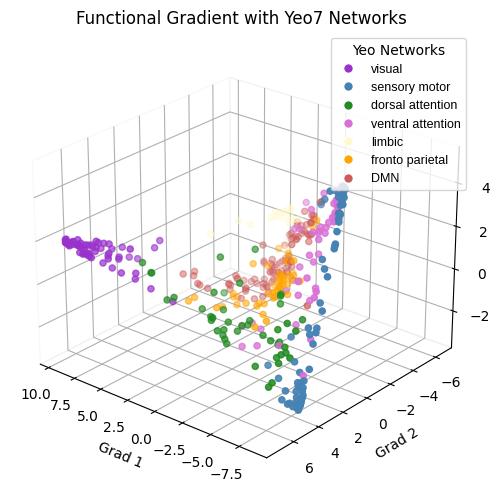

In [41]:
#3D plot sch 
mean_G1_SCH = np.mean(aligned_fc_G1_SCH, axis=0)  # 形状为 [400]
mean_G2_SCH = np.mean(aligned_fc_G2_SCH, axis=0)  # 形状为 [400]
mean_G3_SCH = np.mean(aligned_fc_G3_SCH, axis=0)  # 形状为 [400]

mean_G1_HC = np.mean(aligned_fc_G1_HC, axis=0)
mean_G2_HC = np.mean(aligned_fc_G2_HC, axis=0)
mean_G3_HC = np.mean(aligned_fc_G3_HC, axis=0)
from matplotlib import rcParams
network_names = ["visual", "sensory motor", "dorsal attention", "ventral attention", 
                 "limbic", "fronto parietal", "DMN"]
palette_labeled_networks = {
    'visual': 'darkorchid', 
    'sensory motor': 'steelblue', 
    'dorsal attention': 'forestgreen',
    'ventral attention': 'orchid', 
    'limbic': 'lemonchiffon', 
    'fronto parietal': 'orange', 
    'DMN': 'indianred'
}
colors = [palette_labeled_networks[label] for label in yeo7_networks_array_labels]
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
# Creating plot
ax.scatter3D(mean_fc_grad_SCH.gradients_[:,0], mean_fc_grad_SCH.gradients_[:,1], mean_fc_grad_SCH.gradients_[:,2], color = colors)
legend_labels = [f"{name}" for name in network_names]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labeled_networks[name], 
                      markersize=7, label=name) for name in network_names]

font_properties = {'family': 'Liberation Sans', 'size': 9}
ax.legend(handles=handles, loc='upper right', title="Yeo Networks", fontsize=8, prop=font_properties)
plt.title("Functional Gradient with Yeo7 Networks")
ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3', fontsize=10)
# Remove the outer box lines
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(elev=25, azim=130) #adjust 3D persperctive direction
# Show plot
plt.show()

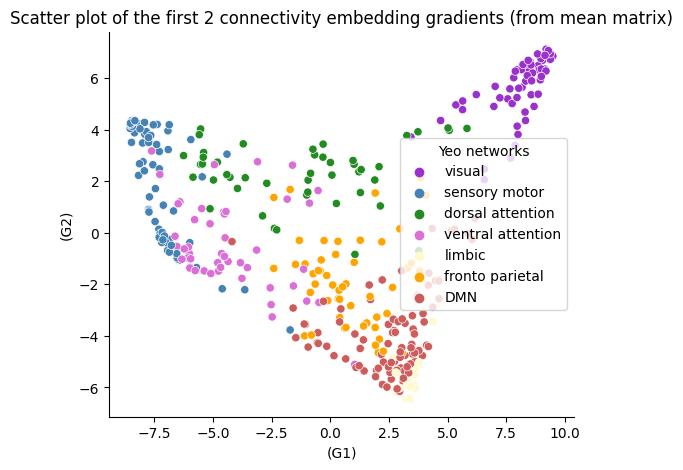

In [46]:
# scatterplot
import seaborn as sns
#hemi_mean_fc_Sch = np.concatenate((mean_fc_grad_lh_Sch.gradients_, mean_fc_grad_rh_Sch.gradients_), axis=0)
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=mean_fc_grad_SCH.gradients_[:,0],  # all rows (400 parces), first column (G1: unimodal - heteromodal)
                     y=mean_fc_grad_SCH.gradients_[:,1],  # all rows (400 parces), second column (G2: visual - somatomotor)
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                     palette=palette_labeled_networks,
                     legend=True, ax=ax);

ax.set_xlabel('(G1)');
ax.set_ylabel('(G2)');
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo networks')
plt.show(ax)

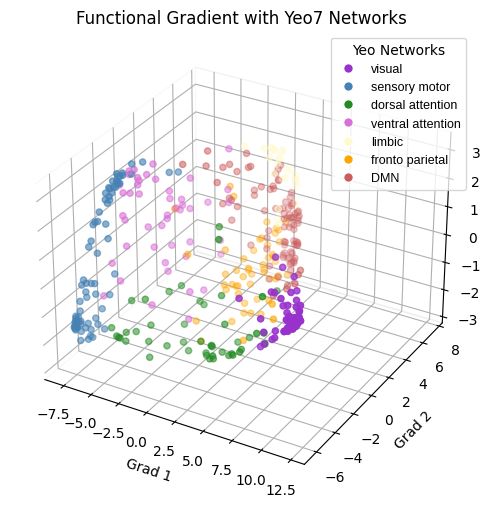

In [47]:
colors = [palette_labeled_networks[label] for label in yeo7_networks_array_labels]
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
# Creating plot
ax.scatter3D(mean_fc_grad_HC.gradients_[:,0], mean_fc_grad_HC.gradients_[:,1], mean_fc_grad_HC.gradients_[:,2], color = colors)
legend_labels = [f"{name}" for name in network_names]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labeled_networks[name], 
                      markersize=7, label=name) for name in network_names]

font_properties = {'family': 'Liberation Sans', 'size': 9}
ax.legend(handles=handles, loc='upper right', title="Yeo Networks", fontsize=8, prop=font_properties)
plt.title("Functional Gradient with Yeo7 Networks")
ax.set_xlabel('Grad 1')
ax.set_ylabel('Grad 2')
ax.set_zlabel('Grad 3', fontsize=10)
# Remove the outer box lines
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
#ax.view_init(elev=25, azim=105) #adjust 3D persperctive direction
# Show plot
plt.show()

In [74]:
participant_ids = [f'sub-{i:03d}' for i in range(1, 46)]  # 命名为 sub-001, sub-002, ..., sub-045
parcels = [f'Parcel_{i+1}' for i in range(400)]  # 对应 400 个 parcel

# 将左右脑的 feature 合并（SCH 和 HC 分别处理）
aligned_fc_G1_SCH = np.concatenate((array_aligned_fc_G1_lh_Sch, array_aligned_fc_G1_rh_Sch), axis=1)
aligned_fc_G2_SCH = np.concatenate((array_aligned_fc_G2_lh_Sch, array_aligned_fc_G2_rh_Sch), axis=1)
aligned_fc_G3_SCH = np.concatenate((array_aligned_fc_G3_lh_Sch, array_aligned_fc_G3_rh_Sch), axis=1)

aligned_fc_G1_HC = np.concatenate((array_aligned_fc_G1_lh_HC, array_aligned_fc_G1_rh_HC), axis=1)
aligned_fc_G2_HC = np.concatenate((array_aligned_fc_G2_lh_HC, array_aligned_fc_G2_rh_HC), axis=1)
aligned_fc_G3_HC = np.concatenate((array_aligned_fc_G3_lh_HC, array_aligned_fc_G3_rh_HC), axis=1)

# 构建 DataFrame
fc_gradient = []
for metric, group, aligned_fc in zip(
    ['G1', 'G2', 'G3', 'G1', 'G2', 'G3'],
    ['SCH', 'SCH', 'SCH', 'HC', 'HC', 'HC'],
    [aligned_fc_G1_SCH, aligned_fc_G2_SCH, aligned_fc_G3_SCH, aligned_fc_G1_HC, aligned_fc_G2_HC, aligned_fc_G3_HC]
):
    for pid_idx, participant_id in enumerate(participant_ids):
        for parcel_idx, measure in enumerate(aligned_fc[pid_idx, :]):
            fc_gradient.append({
                'participant_id': participant_id,
                'group': group,
                'gradient': metric,
                'network': yeo7_networks_array_labels[parcel_idx],
                'value': measure,
                'parcel': parcels[parcel_idx]
            })
df_gradients_networks = pd.DataFrame(fc_gradient)
df_gradients_networks.to_csv('/media/garlicseed/data2/Schizophrenia/FC/sorces/df_gradients_networks.csv', sep=',')

In [ ]:
#geodesic surface plots
mean_geodesic = np.array(sum(mean_geodesic_distances)/len(mean_geodesic_distances))
# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0


mean_geodesic_mapped_to_labels = map_to_labels(mean_geodesic, labeling, mask=mask, fill=np.nan)  

mean_geodesic_plotted_hemispheres = plot_hemispheres(
    f32k_lh, 
    f32k_rh, 
    array_name = mean_geodesic_mapped_to_labels, 
    embed_nb = True, 
    size = (1400,200), 
    cmap = "Oranges",  
    color_bar = True, 
    #color_range='sym',
    nan_color = (0.7, 0.7, 0.7, 1),
    label_text = ["mean geodesic"],
    zoom = 1.45, 
    screenshot = False,
    filename = '/media/garlicseed/data2/Schizophrenia/GD/Figures/gd_hemispheres_mean_distances.png'
)

mean_geodesic_plotted_hemispheres

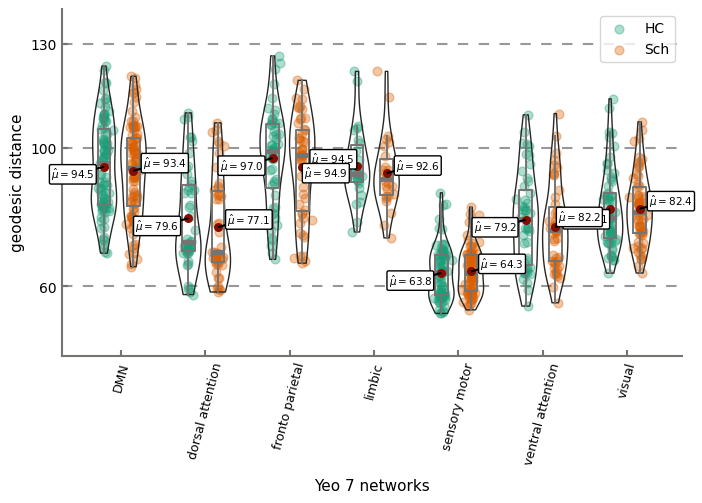

In [215]:
#geodesic scatter plots
# creating lists containing only male and only female fc matrices
import pandas as pd
mean_geodesic_distances = pd.read_csv('/media/garlicseed/data2/Schizophrenia/GD_train/mean_geodesic_distances.csv',header=None)
schz_mask = df['diagnosis'] == 'SCHZ'
hc_mask = df['diagnosis'] == 'CONTROL'
mean_geodesic_distances_Sch = np.array(mean_geodesic_distances[schz_mask])
mean_geodesic_distances_HC = np.array(mean_geodesic_distances[hc_mask])
mean_geodesic_Sch = np.array(sum(mean_geodesic_distances_Sch)/len(mean_geodesic_distances_Sch))
mean_geodesic_HC = np.array(sum(mean_geodesic_distances_HC)/len(mean_geodesic_distances_HC))


df_geo_networks_Sch = pd.DataFrame({'geodesic distance':  mean_geodesic_Sch,  'group': ['Sch']*len(mean_geodesic_Sch), 'Yeo 7 networks' : yeo7_networks_array_labels})
df_geo_networks_HC = pd.DataFrame({'geodesic distance':  mean_geodesic_HC, 'group': ['HC']*len(mean_geodesic_HC), 'Yeo 7 networks' : yeo7_networks_array_labels})
df_geo_networks = pd.concat([df_geo_networks_Sch, df_geo_networks_HC])



#Plot
import pandas as pd
import math
df_scores =df_geo_networks
import matplotlib.pyplot as plt
from mlxtend.evaluate import permutation_test
from scipy.stats import ttest_1samp
import numpy as np
import seaborn as sns
import scipy.stats as st
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"
mask_names = sorted(df_scores["group"].unique())
conditions = sorted(df_scores["Yeo 7 networks"].unique())

fig, ax = plt.subplots(figsize=(8,4.5))
jitter_dot = 0.025
jitter = 0.35  # Increase the jitter or separation between mofc and lofc
HLINES = [60,100, 130]
COLOR_SCALE = ["#1B9E77", "#D95F02"]
#fig.patch.set_facecolor(BG_WHITE)
#ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)
for i, condition in enumerate(conditions):
    for j, mask_name in enumerate(mask_names):
        y_data = df_scores[(df_scores["group"] == mask_name) & (df_scores["Yeo 7 networks"] == condition)]["geodesic distance"].values.astype(float)
        y_data_scale = y_data
        y_base = np.full_like(y_data_scale, 50)


        x_data = np.array([i + j * jitter] * len(y_data_scale))
        x_data = x_data + st.t(df=6, scale=jitter_dot).rvs(len(x_data)) # add jittering to the x_data
        ax.scatter(x_data, y_data_scale, s = 40, color=COLOR_SCALE[j], alpha=0.35, label=mask_name if i == 0 else "")
        
        mean_val = y_data_scale.mean() # Calculate the mean
        ax.scatter(i + j * jitter, mean_val, s=30, color=RED_DARK, zorder=3) # Add red dot for mean
        ts = ''
        if mask_name == "Sch":
            ha = 'left'
            pos = i + j * jitter + 0.11
            text_position = mean_val + 2.2
        else:  # 对于 lofc 或者其他情况
            ha = 'right'
            pos = i + j * jitter - 0.11
            text_position = mean_val - 2.2

        # 计算文字和均值点之间的角度
        delta_x = pos - (i + j * jitter)
        delta_y = text_position - mean_val
        angle = math.atan2(delta_y, delta_x)

        # 为旋转角度加上一个微调值，这里以一定弧度为例，您可以根据需要调整
        # 这会轻微地改变直线的角度。对于 'mofc' 我们减小角度。
        angle_tweak = 0.1
        angle -= angle_tweak  # 减小角度以便让线条向下延伸


        # 计算直线的长度
        line_length = math.sqrt(delta_x**2 + delta_y**2)

        # 计算旋转后的直线终点坐标，保持长度不变
        new_x = (i + j * jitter) + math.cos(angle) * line_length
        new_y = mean_val + math.sin(angle) * line_length

        # 绘制旋转后的直线（从红点到新的终点）
        ax.plot([i + j * jitter, new_x], [mean_val, new_y], ls="dashdot", color="black", zorder=3)

        # 添加文本
        ax.text(pos, text_position, r"$\hat{\mu} = $" + str(round(mean_val, 1)), 
                fontsize=7.5, va="center", color="black", ha=ha,
                bbox=dict(
                    facecolor="white",
                    edgecolor="black",
                    boxstyle="round",
                    pad=0.15
                ), zorder=10)
        
        
        violins = ax.violinplot(y_data_scale, positions=[i + j * jitter], widths=0.3,
                                bw_method="silverman", showmeans=False, showmedians=False, showextrema=False)
        for pc in violins["bodies"]:
            pc.set_facecolor('none')
            pc.set_edgecolor(BLACK)
            pc.set_linewidth(1)
            pc.set_alpha(1)
            
        boxprops = dict(linewidth=1.4, color=GREY_DARK)
        medianprops = dict(linewidth=3.5, color=GREY_DARK, solid_capstyle="butt")
        ax.boxplot(y_data_scale, positions=[i + j * jitter], widths=0.15, showcaps=False, 
                    boxprops=boxprops, medianprops=medianprops, whiskerprops=boxprops, showfliers=False)

        ax.text(i + j * jitter  , np.max(y_data_scale)+0.02, ts, {'fontsize': 11, 'ha': 'center', 'fontweight': 'normal'})
        
# Adjust the x ticks position and labels to be in the middle of mofc and lofc
ax.set_xticks(np.arange(0.2, len(conditions), 1))
ax.set_xticklabels(conditions, size=9, ha="center", ma="center", rotation=75)
#ax.set_xticklabels(conditions, rotation=0)
#ax.legend(loc='upper left')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
ax.spines["left"].set_color(GREY_DARK)
ax.spines["left"].set_linewidth(1.5)
ax.spines["bottom"].set_color(GREY_DARK)
ax.spines["bottom"].set_linewidth(1.5)
plt.ylim(40, 140)
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=10)
ax.set_ylabel("geodesic distance", size=11)
ax.set_xlabel("Yeo 7 networks", size=11)
ax.xaxis.labelpad += 5
ax.legend(loc='upper right', fontsize=10)
ax.tick_params(axis='both', which='major', length=4, width=1.5,color = GREY_DARK,direction='in')
plt.savefig("/media/garlicseed/data2/Schizophrenia/GD/Figures/geo_yeo7.svg", dpi=300, format="svg", bbox_inches='tight')
plt.savefig("/media/garlicseed/data2/Schizophrenia/GD/Figures/geo_yeo7.png", dpi=300, format="png", bbox_inches='tight')
plt.show()

In [212]:
mean_geodesic_distances = pd.read_csv('/media/garlicseed/data2/Schizophrenia/GD_train/mean_geodesic_distances.csv',header=None)
schz_mask = df['diagnosis'] == 'SCHZ'
hc_mask = df['diagnosis'] == 'CONTROL'
mean_geodesic_distances_Sch = np.array(mean_geodesic_distances[schz_mask])
mean_geodesic_distances_HC = np.array(mean_geodesic_distances[hc_mask])
geodesic = np.concatenate([mean_geodesic_distances_Sch, mean_geodesic_distances_HC])

In [213]:
geodesic.shape

(332, 400)

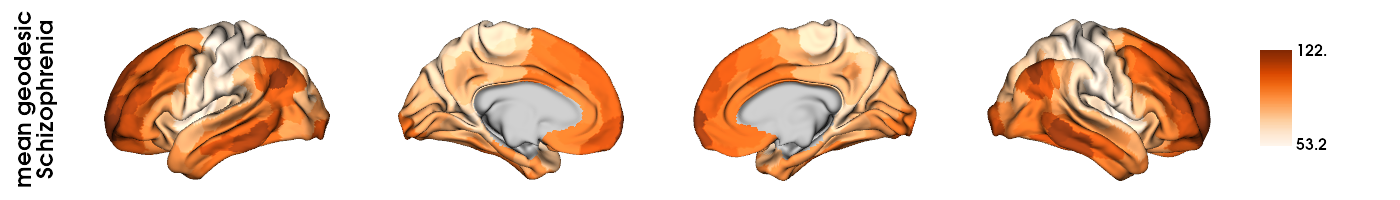

In [216]:
# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0


mean_geodesic_mapped_to_labels = map_to_labels(mean_geodesic_Sch, labeling, mask=mask, fill=np.nan)  

mean_geodesic_plotted_hemispheres = plot_hemispheres(
    surf_lh, 
    surf_rh, 
    array_name = mean_geodesic_mapped_to_labels, 
    embed_nb = True, 
    size = (1400,200), 
    cmap = "Oranges",  
    color_bar = True, 
    #color_range='sym',
    nan_color = (0.7, 0.7, 0.7, 1),
    label_text = ["mean geodesic\nSchizophrenia"],
    zoom = 1.45, 
    screenshot = False,
    filename = '/media/garlicseed/data2/Schizophrenia/GD/Figures/gd_hemispheres_mean_distances_Sch.png'
)

mean_geodesic_plotted_hemispheres

In [23]:
def plot_functional_matrix(fc_matrix, 
                           colormap='viridis', 
                           bar_thickness=20,down_lim=0, top_lim=1):
    """
    Plot a functional connectivity matrix with network color bars.

    Parameters:
    - fc_matrix : np.ndarray
        The functional connectivity matrix to be plotted.
    - network_affiliation_file : str
        File path to the network affiliation data (1D array).
    - color_palette : dict
        Dictionary mapping network labels to their corresponding colors.
    - colormap : str or matplotlib.colors.Colormap, optional
        Colormap to use for the heatmap. Default is 'viridis'.
    - bar_thickness : int, optional
        Thickness of the color bars. Default is 20.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    from matplotlib.patches import Rectangle
    # Load network affiliation data
    yeo7_networks_array = np.genfromtxt('/media/garlicseed/data2/Schizophrenia/surfaces/schaefer400x7CommunityAffiliation.1D', delimiter=',', skip_header=0)

    # Create separate labels for left and right hemispheres
    yeo7_networks_array_labels = []
    for i, val in enumerate(yeo7_networks_array):
        if i < 200:  # First 200 are left hemisphere
            prefix = "LH"
        else:  # Last 200 are right hemisphere
            prefix = "RH"

        if val == 1:
            yeo7_networks_array_labels.append(f'{prefix}_visual')
        elif val == 2:
            yeo7_networks_array_labels.append(f'{prefix}_sensory_motor')
        elif val == 3:
            yeo7_networks_array_labels.append(f'{prefix}_dorsal_attention')
        elif val == 4:
            yeo7_networks_array_labels.append(f'{prefix}_ventral_attention')
        elif val == 5:
            yeo7_networks_array_labels.append(f'{prefix}_limbic')
        elif val == 6:
            yeo7_networks_array_labels.append(f'{prefix}_fronto_parietal')
        elif val == 7:
            yeo7_networks_array_labels.append(f'{prefix}_DMN')
    yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)

    # Network names with left and right hemisphere labels
    network_names = [
        "LH_visual", "LH_sensory_motor", "LH_dorsal_attention", "LH_ventral_attention", "LH_limbic", "LH_fronto_parietal", "LH_DMN",
        "RH_visual", "RH_sensory_motor", "RH_dorsal_attention", "RH_ventral_attention", "RH_limbic", "RH_fronto_parietal", "RH_DMN"
    ]

    # Update color palette for left and right hemispheres
    palette_labeled_networks = {
        'LH_visual': 'darkorchid',
        'LH_sensory_motor': 'steelblue',
        'LH_dorsal_attention': 'forestgreen',
        'LH_ventral_attention': 'orchid',
        'LH_limbic': 'lemonchiffon',
        'LH_fronto_parietal': 'orange',
        'LH_DMN': 'indianred',
        'RH_visual': 'darkorchid',
        'RH_sensory_motor': 'steelblue',
        'RH_dorsal_attention': 'forestgreen',
        'RH_ventral_attention': 'orchid',
        'RH_limbic': 'lemonchiffon',
        'RH_fronto_parietal': 'orange',
        'RH_DMN': 'indianred'
    }


    # Calculate the boundaries of each network
    unique_networks, indices, network_counts = np.unique(yeo7_networks_array_labels, return_index=True, return_counts=True)
    sorted_indices = np.argsort(indices)  # Sort by original indices
    unique_networks = unique_networks[sorted_indices]
    network_counts = network_counts[sorted_indices]
    network_boundaries = np.cumsum(network_counts)
    network_boundaries = np.insert(network_boundaries, 0, 0)

    # Function to add color bars
    def add_colorbar(ax, boundaries, labels, colors, orientation='top', bar_thickness=10):
        for i in range(len(boundaries) - 1):
            start = boundaries[i]
            end = boundaries[i + 1]
            network_name = labels[start]
            color = colors[network_name]

            if orientation == 'top':
                rect = Rectangle((start, -bar_thickness), end - start, bar_thickness, facecolor=color, edgecolor='none')
                ax.add_patch(rect)
            elif orientation == 'left':
                rect = Rectangle((-bar_thickness, start), bar_thickness, end - start, facecolor=color, edgecolor='none')
                ax.add_patch(rect)

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(6, 6))

    # Display the functional connectivity matrix
    im = ax.imshow(fc_matrix, cmap=colormap)

    # Add color bars to the top and left
    add_colorbar(ax, network_boundaries, yeo7_networks_array_labels, palette_labeled_networks, orientation='top', bar_thickness=bar_thickness)
    add_colorbar(ax, network_boundaries, yeo7_networks_array_labels, palette_labeled_networks, orientation='left', bar_thickness=bar_thickness)

    # Add dividing lines between hemispheres
    ax.axhline(y=200, color='black', linewidth=0.6)
    ax.axhline(y=400, color='black', linewidth=0.6)
    ax.axvline(x=200, color='black', linewidth=0.6)
    ax.axvline(x=400, color='black', linewidth=0.6)

    # Add a colorbar for the heatmap
    cbar = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.04)
    cbar.mappable.set_clim(down_lim, top_lim)
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(size=0)

    # Remove the heatmap border
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Adjust plot limits to accommodate color bars
    ax.set_xlim(-bar_thickness, fc_matrix.shape[1])
    ax.set_ylim(fc_matrix.shape[0], -bar_thickness)

    # Remove ticks and labels from the main axes
    ax.set_xticks([])
    ax.set_yticks([])

    # Show the plot
    plt.show()

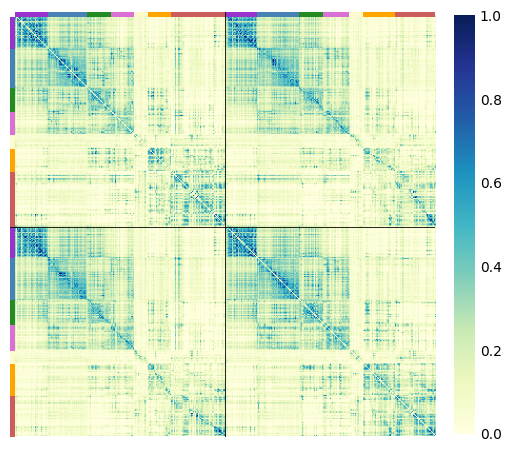

In [24]:
# plot funcational matrix
colorbar_colors = ['#FFFFDFFF', '#EDF8BFFF', '#C7E9B4FF', '#7FCDBBFF', 
          '#41B6C4FF', '#1D91C0FF', '#225EA8FF', '#253494FF', '#081D58FF']

from matplotlib.colors import LinearSegmentedColormap

# Create a custom linear colormap
continuous_cmap = LinearSegmentedColormap.from_list("continuous", colorbar_colors)
fc_stack_first_45 = fc_stack[:45] # 计算前 45 个矩阵的平均值 
fc_stack_mean = np.mean(fc_stack_first_45, axis=0)
plot_functional_matrix(fc_stack_mean, colormap=continuous_cmap,bar_thickness=5)

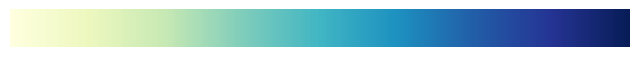

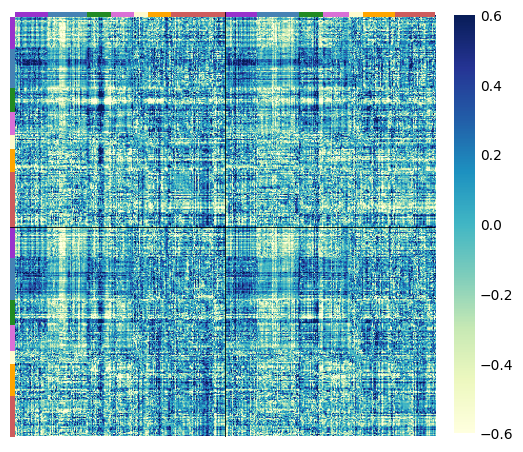

In [39]:
# plot TD matrix
import os
import numpy as np
import pandas as pd

# 指定文件夹路径
data_path = "/media/garlicseed/data2/Schizophrenia/time_delay/time_lag_estimation"

# 初始化一个空的列表用于存储每个被试的数据
data_list = []

# 遍历文件夹中的所有文件，按名称排序（确保顺序正确）
for i in range(1, 91):  # 假定有 90 个被试，编号从 001 到 090
    file_name = f"sub-{i:03d}_timeDelay.csv"
    file_path = os.path.join(data_path, file_name)
    
    # 检查文件是否存在
    if os.path.exists(file_path):
        # 读取 CSV 文件并转换为 NumPy 数组
        data = pd.read_csv(file_path, header=None).values  # 假定没有 header 行
        # 检查形状是否为 (400, 400)
        if data.shape == (400, 400):
            data_list.append(data)
        else:
            print(f"Warning: File {file_name} has an unexpected shape: {data.shape}")
    else:
        print(f"Error: File {file_name} does not exist!")

        
colorbar_colors = ['#FFFFDFFF', '#EDF8BFFF', '#C7E9B4FF', '#7FCDBBFF', 
          '#41B6C4FF', '#1D91C0FF', '#225EA8FF', '#253494FF', '#081D58FF']

from matplotlib.colors import LinearSegmentedColormap

# Create a custom linear colormap
continuous_cmap = LinearSegmentedColormap.from_list("continuous", colorbar_colors)
# 计算前 45 个矩阵的平均值，忽视 NaN 值
TD_first_45 = data_list[:45]  # 提取前 45 个矩阵
TD_mean = np.nanmean(TD_first_45, axis=0)  # 忽视 NaN 值进行平均

plot_functional_matrix(TD_mean, colormap=continuous_cmap, bar_thickness=5,down_lim =-0.6, top_lim = 0.6)
